# Text Classification with Unsloth + LLaMA3

In [1]:
# install Unsloth and other dependencies
%%capture
import os

if "COLAB_" not in "".join(os.environ.keys()):
    !pip install --no-deps unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf==3.20.3 datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

# Load Base Model: LLaMA3 8B 4bit
Using Unsloth for efficient memory usage and RoPE scaling.

In [2]:
import torch
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

torch.backends.cuda.matmul.allow_tf32 = True

context_len = 2048
model_dtype = None
load_4bit = True

model_name_base = "unsloth/llama-3-8b-bnb-4bit"

model_llama, tokenizer_llama = FastLanguageModel.from_pretrained(
    model_name=model_name_base,
    load_in_4bit=load_4bit,
    max_seq_length=context_len,
    dtype=model_dtype,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch SmolVLMForConditionalGeneration forward function.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

# Prune the Classification Head
Only allow "Yes" and "No" outputs for emotion classification.

In [3]:
yes_token = tokenizer_llama.encode("Yes", add_special_tokens=False)[0]
no_token = tokenizer_llama.encode("No", add_special_tokens=False)[0]

new_lm_head = torch.nn.Parameter(torch.vstack([
    model_llama.lm_head.weight[no_token, :],
    model_llama.lm_head.weight[yes_token, :],
]))
model_llama.lm_head.weight = new_lm_head
print("New LM Head shape:", model_llama.lm_head.weight.shape)

New LM Head shape: torch.Size([2, 4096])


# Insert LoRA Adapters
For lightweight efficient fine-tuning.

In [4]:
model_llama = FastLanguageModel.get_peft_model(
    model_llama,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
        "lm_head"
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
    use_rslora=True,
)
print("Trainable params:", sum(p.numel() for p in model_llama.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.4.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
Trainable params: 41951232


# Load Emotion Dataset
New task: Detect if the emotion is **joy** or not.

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Training samples: 12800, Validation samples: 3200


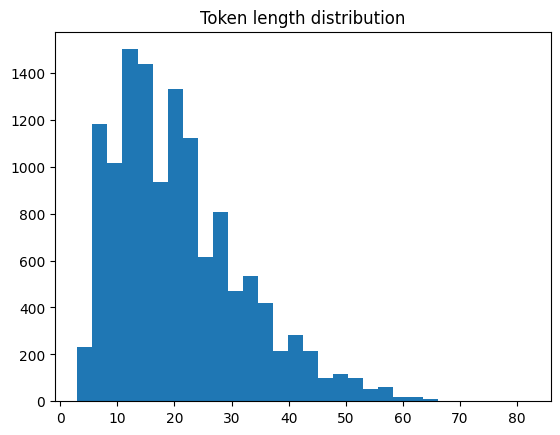

In [5]:
emotion_data = datasets.load_dataset("dair-ai/emotion", split="train")

# transform into binary:
def prepare_emotion(batch):
    batch["label"] = 1 if batch["label"] == 2 else 0
    return batch

emotion_data = emotion_data.map(prepare_emotion)

# split the data
train_data, val_data = emotion_data.train_test_split(test_size=0.2, seed=42).values()
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

# visualize token lengths
plt.hist([len(tokenizer_llama.encode(x)) for x in train_data["text"]], bins=30)
plt.title("Token length distribution")
plt.show()

# Create Classification Prompts
Format text into a classification prompt for the model.

In [6]:
prompt_template = """Here is a user message:
{}

Is the user's emotion JOY? Answer with "Yes" or "No".

Correct Answer: "{}"
"""

def generate_prompt_emotion(batch):
    texts = []
    for text, label in zip(batch["text"], batch["label"]):
        label_text = "Yes" if label == 1 else "No"
        texts.append(prompt_template.format(text, label_text))
    return {"text": texts}

train_data = train_data.map(generate_prompt_emotion, batched=True)
val_data = val_data.map(generate_prompt_emotion, batched=True)

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

# Custom Last-Token Loss Collator
Compute loss only on classification token.

In [7]:
from transformers import DataCollatorForLanguageModeling
from typing import List, Dict, Any, Union

class LastTokenCollator(DataCollatorForLanguageModeling):
    def __init__(self, tokenizer, ignore_index=-100):
        super().__init__(tokenizer, mlm=False)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)
        for i in range(len(batch["labels"])):
            valid = (batch["labels"][i] != self.ignore_index).nonzero()
            last_idx = valid[-1].item()
            batch["labels"][i, :last_idx] = self.ignore_index
            batch["labels"][i, last_idx] = 1 if batch["labels"][i, last_idx] == yes_token else 0
        return batch

collator = LastTokenCollator(tokenizer=tokenizer_llama)

# Fine-tuning the model!
Train LLaMA3 for emotion classification.

In [8]:
trainer = SFTTrainer(
    model=model_llama,
    tokenizer=tokenizer_llama,
    train_dataset=train_data,
    max_seq_length=context_len,
    dataset_num_proc=2,
    args=TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,
        weight_decay=0.01,
        logging_steps=1,
        lr_scheduler_type="cosine",
        warmup_steps=10,
        num_train_epochs=1,
        output_dir="outputs",
        bf16=torch.cuda.is_bf16_supported(),
        fp16=not torch.cuda.is_bf16_supported(),
        report_to="none",
        group_by_length=True,
        seed=42,
    ),
    formatting_func=lambda x: x["text"],
    data_collator=collator,
)

trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/12800 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,800 | Num Epochs = 1 | Total steps = 400
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 41,951,232/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.982500
2,0.989100
3,0.966900
4,0.358000
5,0.020100
6,0.000400
7,0.000800
8,0.001100
9,0.000200
10,0.002200


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=400, training_loss=0.008859001323580742, metrics={'train_runtime': 244.1109, 'train_samples_per_second': 52.435, 'train_steps_per_second': 1.639, 'total_flos': 2.783094278455296e+16, 'train_loss': 0.008859001323580742})

# Inference on Validation Set
Quick evaluation of accuracy.

In [9]:
FastLanguageModel.for_inference(model_llama)

correct_preds = 0
for rec in val_data:
    inputs = tokenizer_llama(prompt_template.format(rec["text"], ""), return_tensors="pt").to("cuda")
    outputs = model_llama.generate(**inputs, max_new_tokens=1)
    prediction = tokenizer_llama.decode(outputs[0], skip_special_tokens=True).lower()

    label_text = "yes" if rec["label"] == 1 else "no"
    if label_text in prediction:
        correct_preds += 1

print(f"Validation Accuracy: {correct_preds/len(val_data):.2%}")

Validation Accuracy: 100.00%


# Save your model!

In [10]:
model_llama.save_pretrained("finetuned_llama_emotion")
tokenizer_llama.save_pretrained("finetuned_llama_emotion")

('finetuned_llama_emotion/tokenizer_config.json',
 'finetuned_llama_emotion/special_tokens_map.json',
 'finetuned_llama_emotion/tokenizer.json')